In [1]:
# import modules
from pathlib import Path
import numpy as np
import pandas as pd

import cv2
import pydicom
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib notebook

# Introduction

We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

# Preprocessing 

In [2]:
# load labels
labels = pd.read_csv("rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
print(labels.shape)
labels.head()

(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
# remvoing duplicate records on patient level since this is a classification model
labels = labels.drop_duplicates(subset = "patientId")
print(labels.shape)
labels['Target'].value_counts()

(26684, 6)


0    20672
1     6012
Name: Target, dtype: int64

In [4]:
# define paths 
ROOT_PATH = Path("rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("rsna-pneumonia-detection-challenge/Processed")

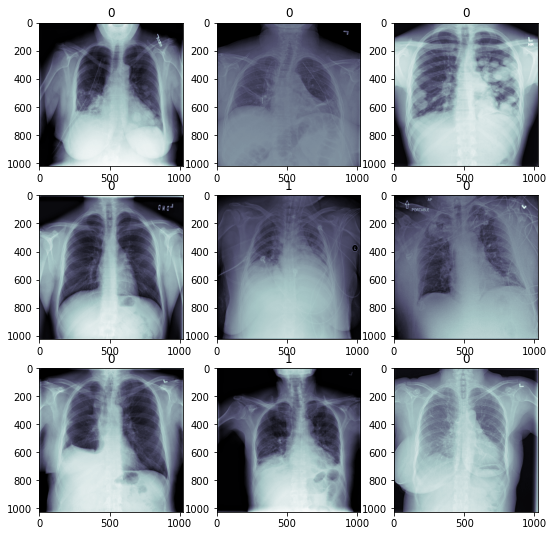

In [6]:
# visualize images
fig, axis = plt.subplots(3,3, figsize=(9,9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

In [7]:
# calculating mean & standard deviation
sums, sums_squared = 0.0, 0.0

for c, patient_id in enumerate(tqdm(labels.patientId)) :
    
    # read the respective dicom file
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array
    
    # normalize by dividing it by 255
    dcm = dcm/255
    
    # convert data type
    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)
    label = labels["Target"].iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    # save the file
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    # normalization
    normalizer = 224*224
    if train_or_val == 'train' :
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer
    

  0%|          | 0/26684 [00:00<?, ?it/s]

In [8]:
mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

In [9]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.4903962485384803, STD: 0.24795070634161256


# Train Model 

In [5]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [6]:
# load file
def load_file(path):
    return np.load(path).astype(np.float32)


In [7]:
# train transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.49, std=0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
    
])

# validation transforms
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.49, std=0.248)
])

In [8]:
train_dataset = torchvision.datasets.DatasetFolder(str(SAVE_PATH/'train'), loader=load_file,
                                                  extensions="npy", transform= train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(str(SAVE_PATH/'val'), loader=load_file,
                                                  extensions="npy", transform= train_transforms)

<IPython.core.display.Javascript object>


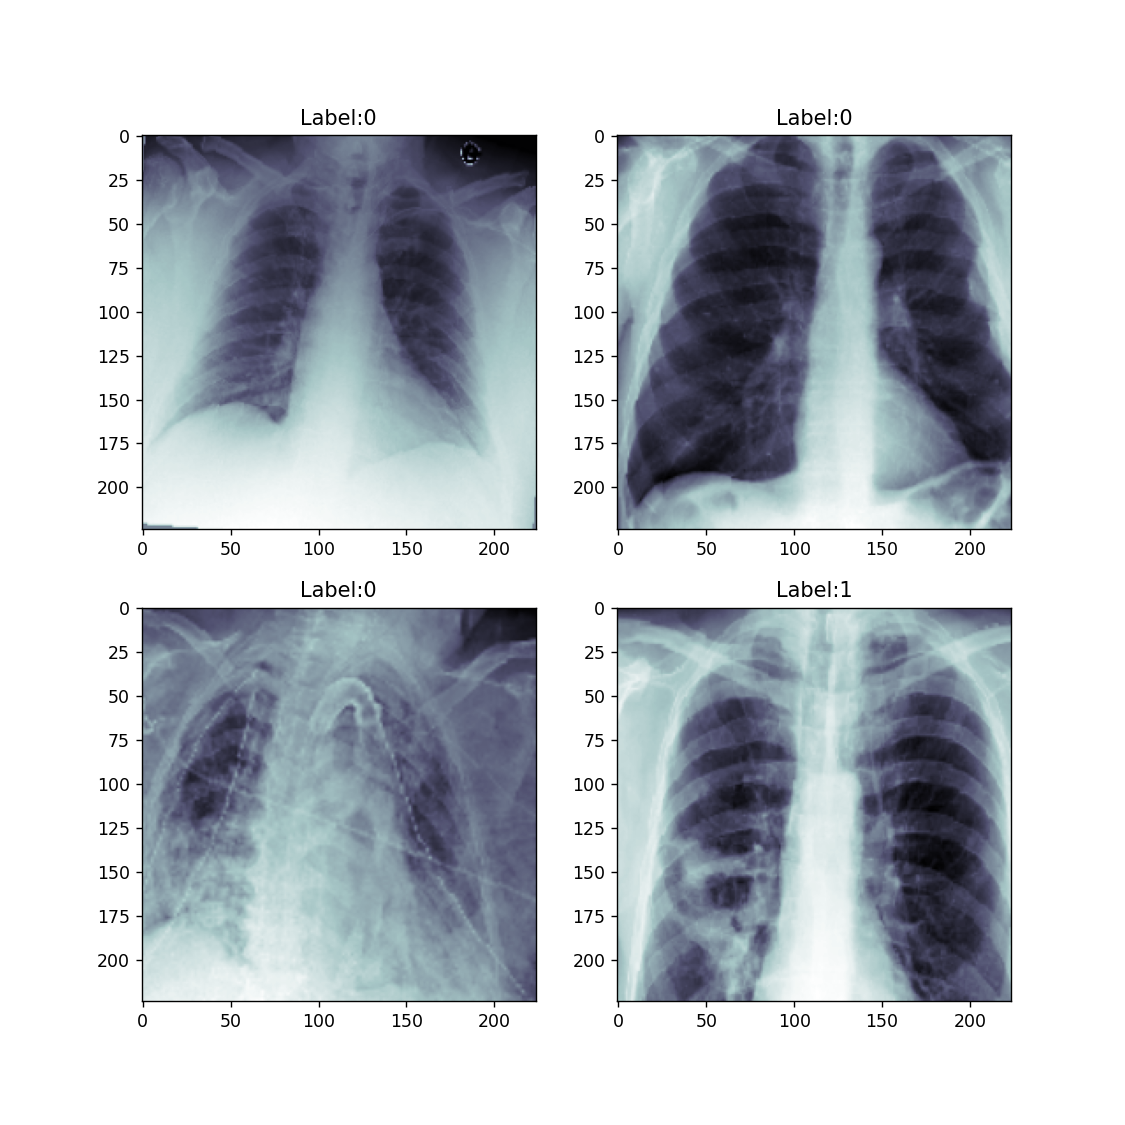

In [9]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [10]:
batch_size = 64
num_workers = 4

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [11]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407], dtype=int64))

In [12]:
np.unique(val_dataset.targets, return_counts=True)

(array([0, 1]), array([2079,  605], dtype=int64))

## Model 

In [13]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [15]:
model = PneumoniaModel() 

In [16]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [17]:
torch.cuda.is_available()

True

In [18]:
gpus =1
trainer = pl.Trainer(gpus= gpus, logger = TensorBoardLogger(save_dir="./logs_pneumonia"), log_every_n_steps=1,
                    num_sanity_val_steps=0, callbacks=checkpoint_callback, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs_pneumonia\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Evaluation

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumoniaModel.load_from_checkpoint("resources/04-Pneumonia-Classification/weights/weights_3.ckpt")
model.eval()
model.to(device);

In [21]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

In [22]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.7820417284965515
Val Precision: 0.5103949904441833
Val Recall: 0.8115702271461487
Confusion Matrix:
 tensor([[1608,  471],
        [ 114,  491]])
Confusion Matrix 2:
 tensor([[1214,  865],
        [  28,  577]])


# Interpretability 

In [26]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# model for interpreabiltiy

class PneumoniaModelInterpretability(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
        
        
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        print(f"Shape of feature_map: {feature_map.shape}")
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(f"Shape of avg_pool_output: {avg_pool_output.shape}")
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(f"Shape of avg_pool_output_flattened: {avg_pool_output_flattened.shape}")
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    


In [40]:
# Use strict to prevent pytorch from loading weights for self.feature_map
model = PneumoniaModelInterpretability.load_from_checkpoint("resources/04-Pneumonia-Classification/weights/weights_3.ckpt", strict=False)
model.eval();

In [44]:
def cam(model, img):
    
    print(img.shape)
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    
    features = features.reshape((512, 49))
    print(f"Shape of features map after reshaping: {features.shape}")
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    print(f"Shape of weight: {weight.shape}")
    
    cam = torch.matmul(weight, features)
    print(f"Shape of cam: {cam.shape}")
    cam_img = cam.reshape(7, 7).cpu()
    
    return cam_img, torch.sigmoid(pred)

In [45]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred > 0.5)

In [54]:
img = val_dataset[-6][0] 
activation_map, pred = cam(model, img)

torch.Size([1, 224, 224])
Shape of feature_map: torch.Size([1, 512, 7, 7])
Shape of avg_pool_output: torch.Size([1, 512, 1, 1])
Shape of avg_pool_output_flattened: torch.Size([512])
Shape of features map after reshaping: torch.Size([512, 49])
Shape of weight: torch.Size([512])
Shape of cam: torch.Size([49])


<IPython.core.display.Javascript object>


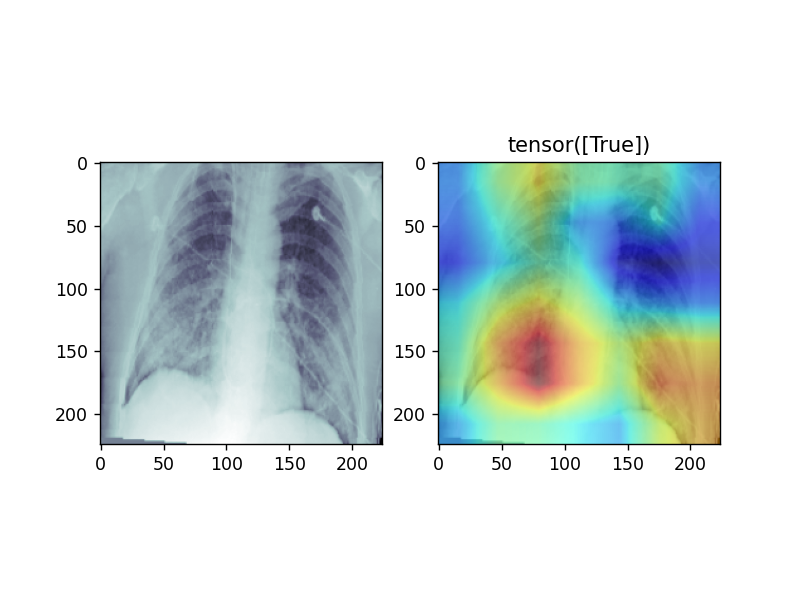

In [57]:
visualize(img, activation_map, pred)